In [2]:
import geopandas as gpd
import xarray as xr
import pandas as pd
from operator import itemgetter
import numpy as np
import scipy.stats as stats
import rioxarray as rioxr
from rasterio.enums import Resampling

from metloom.pointdata import SnotelPointData, MesowestPointData
import datetime as dt
import matplotlib.pyplot as plt
from metloom.variables import SnotelVariables, SensorDescription, MesowestVariables
import shapely
import contextily as cx
import seaborn as sns 

import requests
import json
from dataretrieval import nwis
# used this to access the metadata for CO mesowest stations
# response = requests.get('https://api.synopticdata.com/v2/stations/metadata?&token=bd62c79f64c9433daf0f2f23a0bc1f7e&output=json&state=CO').text

In [264]:
column_dict = {'09034900': 'BOBTAIL CREEK NEAR JONES PASS, CO.',
                '09035900': 'SOUTH FORK OF WILLIAMS FORK NEAR LEAL, CO.',
                '09035800': 'DARLING CREEK NEAR LEAL, CO.',
                '09047700': 'KEYSTONE GULCH NEAR DILLON, CO.',
                '09066000': 'BLACK GORE CREEK NEAR MINTURN, CO.',
                '09065500': 'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
                '09066200': 'BOOTH CREEK NEAR MINTURN, CO.',
                '09066300': 'MIDDLE CREEK NEAR MINTURN, CO.',
                '09081600': 'CRYSTAL RIVER AB AVALANCHE C, NEAR REDSTONE, CO.',
                '09107000': 'TAYLOR RIVER AT TAYLOR PARK, CO.',
                '09110000': 'TAYLOR RIVER AT ALMONT, CO.',
                '09112500': 'EAST RIVER AT ALMONT CO.',
                '09115500': 'TOMICHI CREEK AT SARGENTS, CO.',
                '09119000': 'TOMICHI CREEK AT GUNNISON, CO.',
                '09124500': 'LAKE FORK AT GATEVIEW, CO.',
                '09125000': 'CURECANTI CREEK NEAR SAPINERO, CO.',
                '09128500': 'SMITH FORK NEAR CRAWFORD, CO.',
                '09132500': 'NORTH FORK GUNNISON RIVER NEAR SOMERSET, CO.',
                '09146200': 'UNCOMPAHGRE RIVER NEAR RIDGWAY, CO.',
                '09147500': 'UNCOMPAHGRE RIVER AT COLONA, CO.',
                '09165000': 'DOLORES RIVER BELOW RICO, CO.',
                '09168100': 'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
                '09239500': 'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
                '09241000': 'ELK RIVER AT CLARK, CO.',
                '09245000': 'ELKHEAD CREEK NEAR ELKHEAD, CO.',
                '09250000': 'MILK CREEK NEAR THORNBURGH, CO.',
                '09304500': 'WHITE RIVER NEAR MEEKER, CO.',
                '09352900': 'VALLECITO CREEK NEAR BAYFIELD, CO.',
                '09361500': 'ANIMAS RIVER AT DURANGO, CO.'}

In [3]:
# Get UCRB stations
ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')

# Add 0 to the station  ID
ucrb_hcdn_stations['STAID'] = ['0'+str(id) for id in ucrb_hcdn_stations['STAID']]
ucrb_hcdn_stations = ucrb_hcdn_stations[~ucrb_hcdn_stations['STAID'].isin(['09168100','09250000'])]

# Get basin polygons
basins = gpd.read_file(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\sublimation_of_snow\data\bas_nonref_WestMnts.shp")

# Create new crs and drop one of the columns
ucrb_hcdn_co_gdf = ucrb_hcdn_stations.to_crs(basins.crs)
ucrb_hcdn_co_gdf = ucrb_hcdn_co_gdf.drop('index_right',axis=1)

# Combine to find locations of sites within basins
ucrb_hcdn_combined = gpd.sjoin(basins,ucrb_hcdn_co_gdf)

In [4]:
# Get the smallest basin that matches each gage location
idx = []
for station in ucrb_hcdn_combined['STANAME'].unique():
    tmp = ucrb_hcdn_combined[ucrb_hcdn_combined['STANAME']==station]
    idx.append(tmp.loc[tmp['AREA'].idxmin()])
ucrb_hcdn_basins = gpd.GeoDataFrame(idx, crs=basins.crs)
# Change the crs
ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(epsg='4326')


In [5]:
idx_gages = []
for gage in ucrb_hcdn_basins.GAGE_ID:
    tmp = ucrb_hcdn_basins[ucrb_hcdn_basins.GAGE_ID == gage]
    if tmp['DRAIN_SQKM'].idxmax() not in idx_gages:
        idx_gages.append(tmp['DRAIN_SQKM'].idxmax())

In [6]:
ucrb_hcdn_basins_filtered = ucrb_hcdn_basins.loc[idx_gages].reset_index()
# ucrb_hcdn_basins_filtered.to_file('./ucrb_hcdn_co_polygons_final.json')

### Import HCDN Gaging stations and data

In [7]:
# ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_co_gdf_final.json')
# ucrb_hcdn_stations['geometry'] = gpd.GeoSeries(ucrb_hcdn_stations['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
# ucrb_hcdn_stations = ucrb_hcdn_stations.set_crs(epsg='4326')

station_ids = ucrb_hcdn_basins_filtered['STAID']

hcdn_streamflow_df = nwis.get_dv(sites=station_ids, start='1980-10-01', end='2021-09-30')


In [8]:
df = hcdn_streamflow_df[0]['00060_Mean'].reset_index()

df['datetime']=[d.date() for d in df['datetime']]
df['datetime']= pd.to_datetime(df['datetime'])
df = df.set_index(['site_no','datetime'])
hcdn_q_ds = df.to_xarray()

In [9]:
hcdn_q_spring_summer_ds = hcdn_q_ds.where(hcdn_q_ds.datetime.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('datetime.year').mean()

In [10]:
norm_hcdn_mean_ds = (hcdn_q_spring_summer_mean_ds - hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')
norm_hcdn_mean_ds = norm_hcdn_mean_ds.sel(year=slice(1980,2021))

#### Reproject to 13N UTM Zone

In [131]:
ucrb_hcdn_stations_rpj = ucrb_hcdn_stations[ucrb_hcdn_stations['STAID'].isin(norm_hcdn_mean_ds['site_no'])].to_crs(epsg='32613')

### Import HCDN Basins and reproject to 13N UTM Zone

In [132]:
ucrb_hcdn_basins_rpj = ucrb_hcdn_basins_filtered.to_crs(epsg='32613')
ucrb_hcdn_basins_rpj_centroids = ucrb_hcdn_basins_rpj.geometry.centroid

ucrb_huc4 = gpd.read_file('./ucrb_hcdn_huc4.json')
ucrb_huc4_rpj = ucrb_huc4.to_crs(epsg='32613')

### Pull in all SNTL metadata and MesoNet metadata

In [13]:
# Get SNTL data
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl = gdf_sntl.to_crs(epsg='32613')

# # Get Mesowest data
# mesowest_df = pd.read_json('./mesowest_co_metadata.json')
# mesowest_gdf = gpd.GeoDataFrame(mesowest_df,geometry=gpd.points_from_xy(mesowest_df.LONGITUDE, mesowest_df.LATITUDE), crs='4326')
# mesowest_gdf_rpj = mesowest_gdf.to_crs(epsg='32613')

# start_dates = [dt.datetime.strptime(str(s['start'])[:-1], '%Y-%m-%dT%H:%M:%S') if str(s['start']) !='None' else None for s in mesowest_gdf_rpj['PERIOD_OF_RECORD'] ]
# start_date_series = pd.Series(start_dates, index=mesowest_gdf_rpj.index)
# mswst_start_pre_2000 = start_date_series[start_date_series<dt.datetime(2000,1,1)].index
# mesowest_gdf_rpj = mesowest_gdf_rpj.query("STATUS=='ACTIVE'")
# mesowest_gdf_rpj = mesowest_gdf_rpj.loc[mswst_start_pre_2000]

In [14]:
nearest_sntl = {}

for i,basin in enumerate(ucrb_hcdn_basins_rpj_centroids):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins_rpj.iloc[i]['STAID']] = [site[0] for site in idx_sntl]

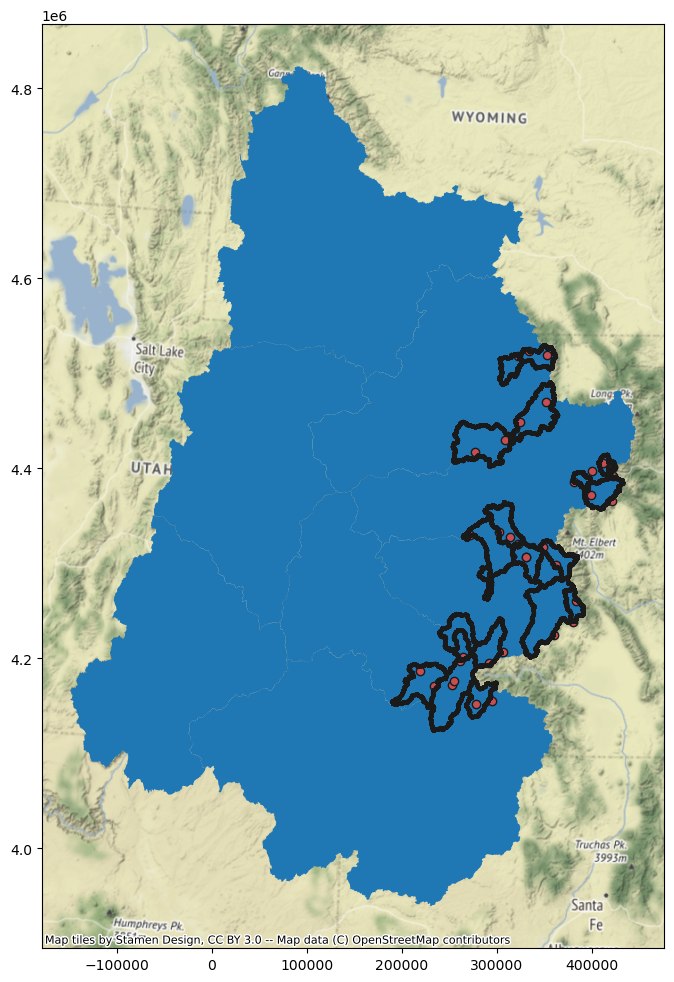

In [175]:

ax=ucrb_hcdn_basins_rpj.boundary.plot(color='k', linewidth=3, label='HCDN Boundaries', figsize=(12,12),edgecolor='k')
ucrb_huc4_rpj.plot(ax=ax)
#Add in hospitals as points
gdf_sntl[gdf_sntl['site_id'].isin([val[0] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', label='SNOTEL Sites', ax=ax)
gdf_sntl[gdf_sntl['site_id'].isin([val[1] for val in list(nearest_sntl.values())])].plot(c="r", alpha=1, ec='k', ax=ax)

#Now adding in the basemap imagery
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.Stamen.Terrain)


In [16]:
northern_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y > 4.35e6)]['STANAME']
central_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y < 4.35e6) & (ucrb_hcdn_basins_rpj_centroids.y > 4.25e6)]['STANAME']
southern_names = ucrb_hcdn_basins_rpj[(ucrb_hcdn_basins_rpj_centroids.y < 4.25e6)]['STANAME']


### Request SNTL data

In [17]:
closest_sntl_swe_ds = xr.open_dataset('./hcdn_closest_sntl_expanded_20220930.nc')
closest_sntl_april_1_swe = closest_sntl_swe_ds.where((closest_sntl_swe_ds.Date.dt.month==4)&(closest_sntl_swe_ds.Date.dt.day==1))['WTEQ'].to_dataframe().dropna().to_xarray()
norm_closest_sntl_april_1_swe = (closest_sntl_april_1_swe-closest_sntl_april_1_swe.mean(dim='Date'))/closest_sntl_april_1_swe.std(dim='Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sortby('Date')
norm_closest_sntl_april_1_swe = norm_closest_sntl_april_1_swe.sel(Date=slice('1981-4-1','2021-4-1'))
norm_closest_sntl_april_1_swe['Date'] = norm_closest_sntl_april_1_swe['Date'].dt.year

if 'datetime' in norm_hcdn_mean_ds.dims:
    norm_hcdn_mean_ds['datetime'] = norm_hcdn_mean_ds['datetime'].dt.year-1

In [18]:
second_sntl_swe_ds = xr.open_dataset('./hcdn_second_closest_sntl_20210930.nc')
second_sntl_april_1_swe = second_sntl_swe_ds.where((second_sntl_swe_ds.Date.dt.month==4)&(second_sntl_swe_ds.Date.dt.day==1))['WTEQ'].to_dataframe().dropna().to_xarray()
norm_second_sntl_april_1_swe = (second_sntl_april_1_swe-second_sntl_april_1_swe.mean(dim='Date'))/second_sntl_april_1_swe.std(dim='Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sortby('Date')
norm_second_sntl_april_1_swe = norm_second_sntl_april_1_swe.sel(Date=slice('1987-4-1','2021-4-1'))
norm_second_sntl_april_1_swe['Date'] = norm_second_sntl_april_1_swe['Date'].dt.year

In [19]:
def linreg_output(swe, q):
    slope, intercept, rvalue, pvalue,stderr  = stats.linregress(swe, q)

    alpha = 0.05
    c = (1 - alpha)

    # Create regression line and residuals
    X = swe
    y_predicted = intercept + slope*X
    residual = (q-y_predicted)

    # Setup 
    n = X.size                                               
    dof = n - 2
    t = stats.t.ppf(c, dof) 

    # sum of squared errors
    sse = np.sum(residual**2)

    # total sum of squares (y)
    sst = np.sum( (q - np.mean(q))**2 )

    # total sum of squares (x)
    sst_x = np.sum( (X - np.mean(X))**2 )

    # correlation coefficient
    r_squared = 1 - sse/sst

    # standard error of regression
    s = np.sqrt(sse/(n-2))

    # an array of x values
    p_x = np.linspace(X.min(),X.max(),100)

    # using our model parameters to predict y values
    p_y = intercept + slope*p_x

    # compute error of prediction for each p_x
    sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
    # set our confidence interval

    p_y_lower = p_y - t * sigma_ep
    p_y_upper = p_y + t * sigma_ep
    return X, intercept, slope, residual, r_squared

In [21]:
groundwater_drawdown_1 = np.arange(2018,2021,1) 
groundwater_drawdown_2 = np.arange(2018,2021,1)
groundwater_drawdown_3 = np.arange(2018,2021,1)
groundwater_drawdown_4 = np.arange(2018,2021,1)

Using Far Location for 09361500


Text(0.5, 0.98, 'SWE-Q Relationship within selected UCRB HCDN Basins')

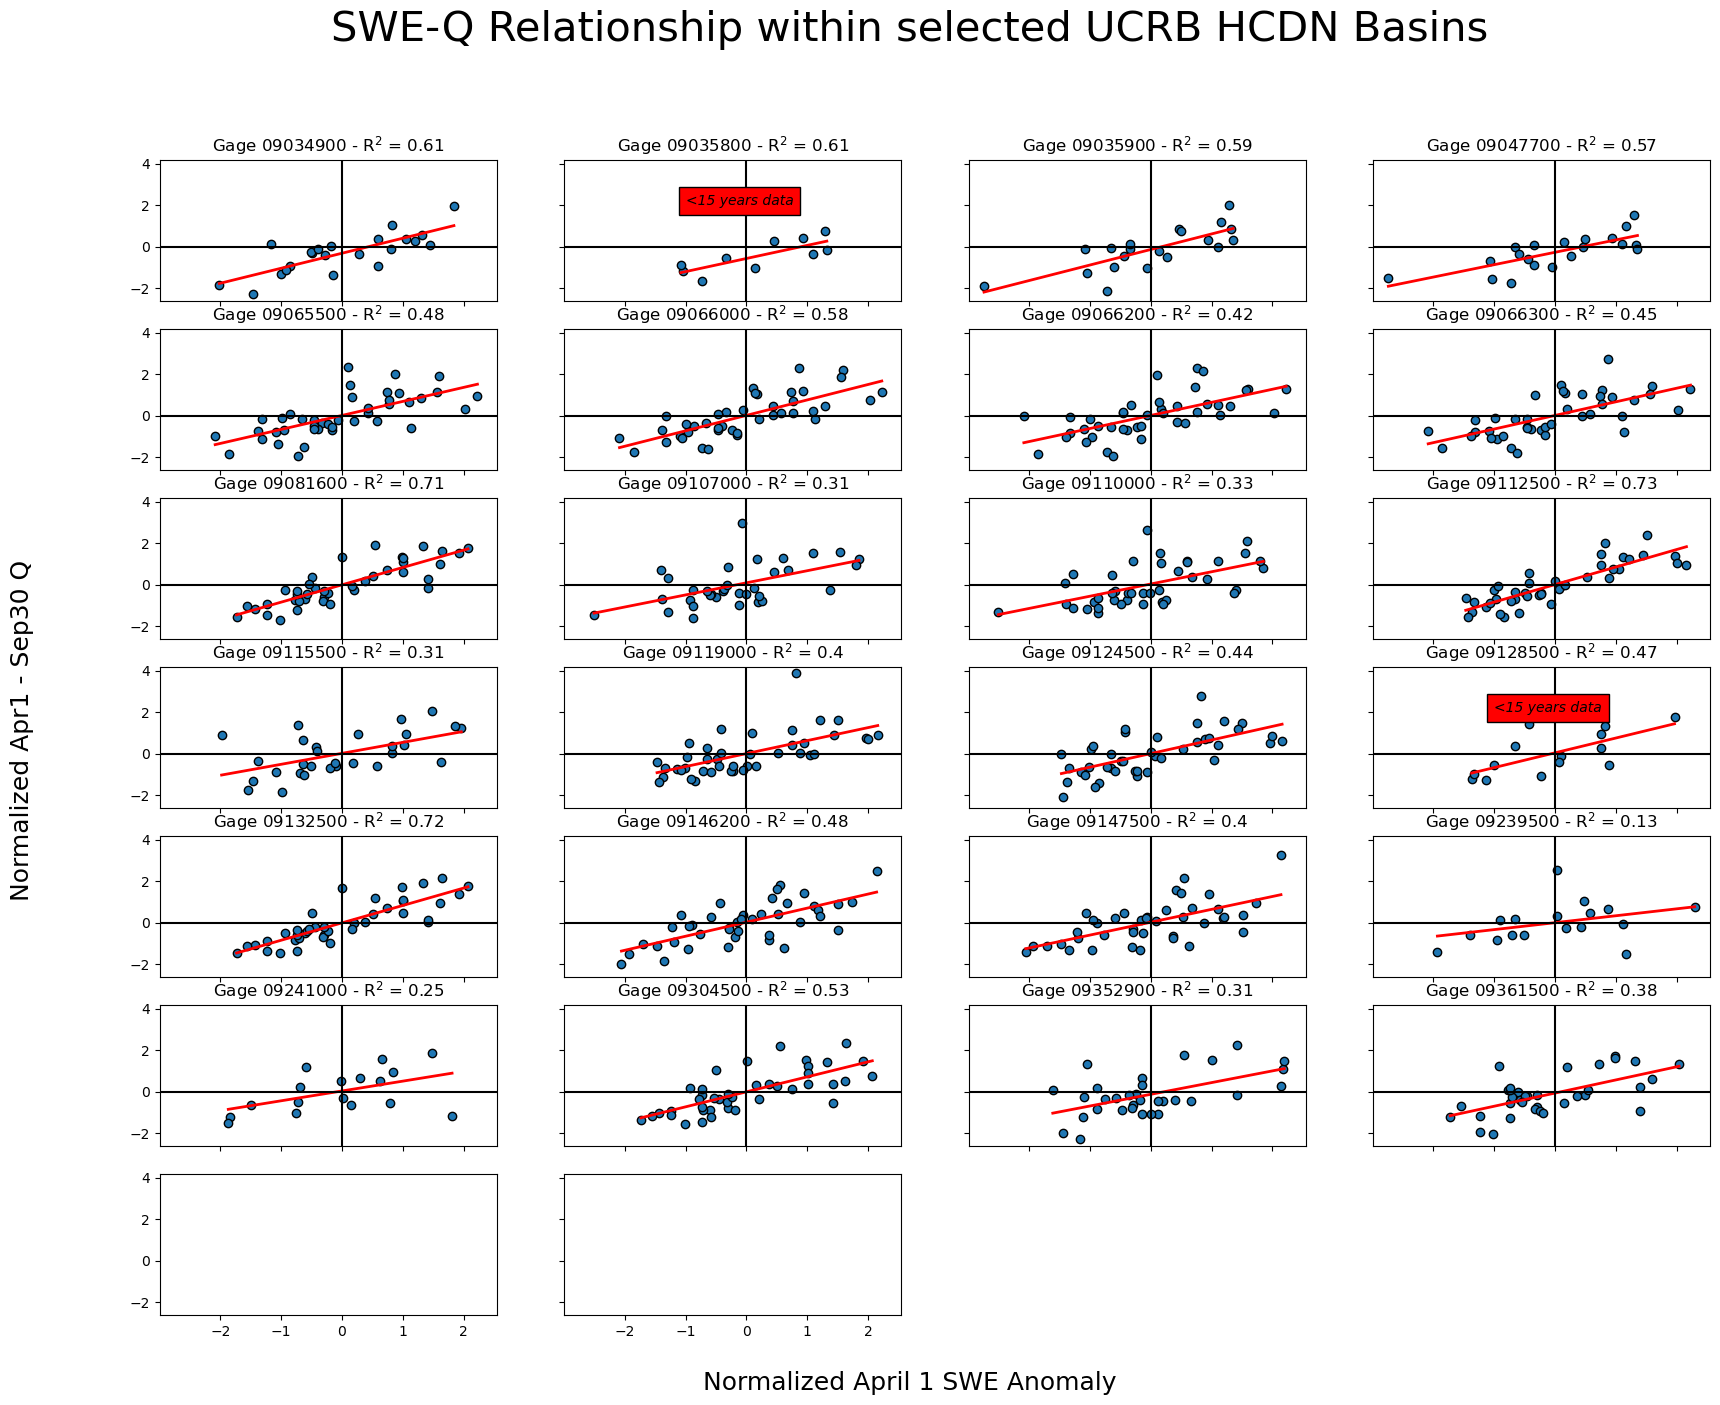

In [20]:
colors = ['#2c7fb8','#7fcdbb']
residuals = {}
fig, axs = plt.subplots(ncols=4, nrows=7, figsize=(20,15), sharex=True, sharey=True, facecolor='white')
axs=axs.ravel()

for i,loc in enumerate(list(norm_hcdn_mean_ds.site_no.values)):
    # Set axis for plotting
    ax=axs[i]
    # get nearest sntl site
    sntl_site_close = nearest_sntl[loc][0]
    sntl_site_far = nearest_sntl[loc][1]

    # Calculate normalized
    if (sntl_site_close not in norm_closest_sntl_april_1_swe.Location):
        print(f'Using Far Location for {loc}')
        sntl_site = sntl_site_far
        normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    elif (len(norm_closest_sntl_april_1_swe.sel(Location=sntl_site_close).to_dataframe().dropna().index) <= 14): 
        print(f'Using Far Location for {loc}')
        sntl_site = sntl_site_far
        normalized_april_1_swe = norm_second_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
    else:
        sntl_site = sntl_site_close
        normalized_april_1_swe = norm_closest_sntl_april_1_swe.sel(Location=sntl_site)['WTEQ'].to_dataframe().dropna() 
       
    normalized_q_apr1_sep30 = norm_hcdn_mean_ds.sel(site_no=loc)['00060_Mean'].to_dataframe().dropna()
    tmp_df = normalized_q_apr1_sep30.merge(normalized_april_1_swe, left_index=True, right_index=True)
    # Filtering to find where
    # tmp_df = tmp_df.where(np.abs(tmp_df['WTEQ'] - tmp_df['00060_Mean']) <2).dropna()

    # Run linreg function to get output
    X, intercept, slope, residual, r_squared = linreg_output(tmp_df['WTEQ'].values, tmp_df['00060_Mean'].values)
    residuals[loc] = pd.Series(residual, index=tmp_df.index)

    # Plotting up each location
    ax.scatter(tmp_df['WTEQ'], tmp_df['00060_Mean'], ec='k')
    # Plotting each bestfit line
    ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color='red',lw=2, label='Best-Fit Line')
    if len(tmp_df.index) < 15:
        ax.text(-1, 2, '<15 years data', style='italic',
        bbox={'facecolor': 'red', 'alpha': 1, 'pad': 5})
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_title(f'Gage {loc} - R$^2$ = {round(r_squared,2)}')
axs[26].axis('off')  
axs[27].axis('off')  
fig.text(0.5, 0.06, 'Normalized April 1 SWE Anomaly', ha='center', size=18)
fig.text(0.05, 0.5, 'Normalized Apr1 - Sep30 Q', va='center', rotation='vertical', size=18)
fig.suptitle(t="SWE-Q Relationship within selected UCRB HCDN Basins", size=30)

In [27]:
ordered_idx = {}
residual_df = pd.DataFrame(residuals)
residual_df = residual_df.rename(columns=dict(zip(ucrb_hcdn_basins_filtered.STAID,ucrb_hcdn_basins_filtered.STANAME)))
for col in residual_df.columns:
    ordered_idx[col] = residual_df[col].sort_values(na_position='last').index
    ordered_idx[f'{col}_flag'] = residual_df[col].sort_values(na_position='last').isna().reset_index(drop=True)

ordered_idx_df = pd.DataFrame(ordered_idx)

In [ ]:
# Figure of residuals

In [78]:
good_col_list = []
for i,col in enumerate(ordered_idx_df.columns):
    if i % 2 != 0:
        if ordered_idx_df[col].sum() <= 5:
            good_col_list.extend([ordered_idx_df.columns[i-1]])

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\geopandas\plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


IndexError: index 24 is out of bounds for axis 0 with size 24

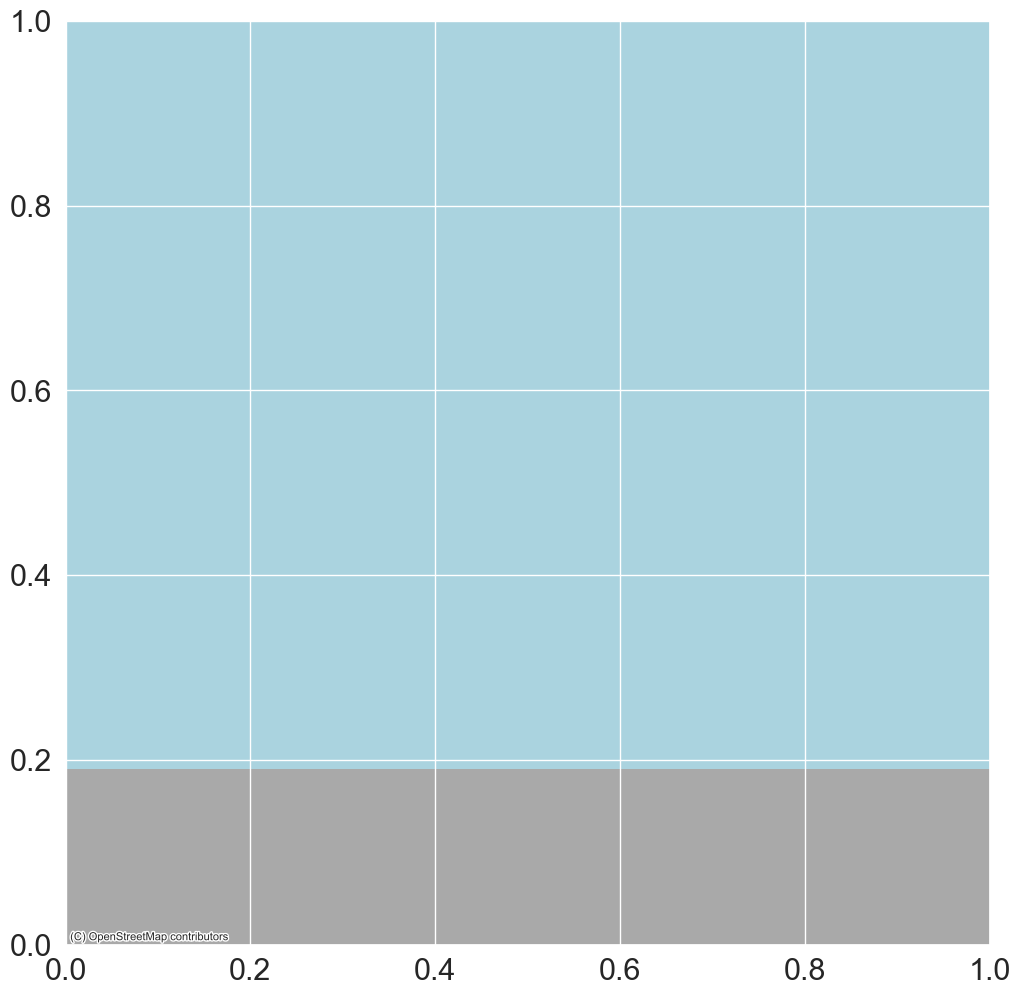

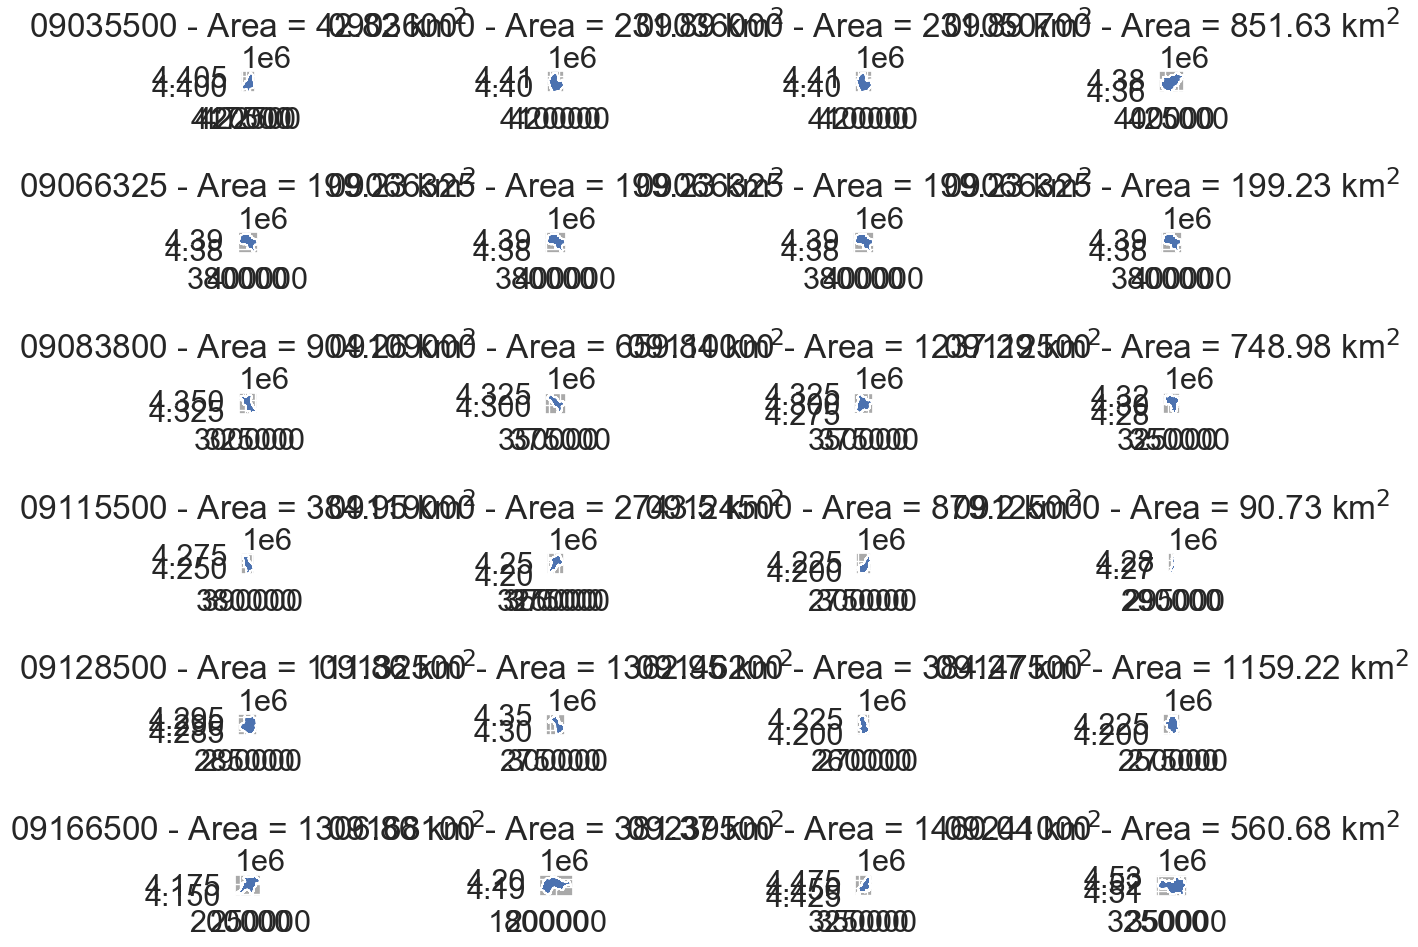

In [79]:
hcdn_huc4 = [ucrb_huc4_rpj.contains(centroid).idxmax() for centroid in ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['GAGE_ID'].isin(good_col_list)].geometry.centroid]
hcdn_huc4 = [*set(hcdn_huc4)]
ax=ucrb_huc4_rpj.loc[hcdn_huc4].plot(color='blue',ec='k', alpha=0.4,figsize=(12,12))

ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['GAGE_ID'].isin(good_col_list)].geometry.centroid.plot(color='k', linewidth=3, label='HCDN Centroids', edgecolor='k', ax=ax)
for name in ucrb_huc4_rpj.loc[hcdn_huc4]['name']:
    cnt = ucrb_huc4_rpj[ucrb_huc4_rpj['name']==name].geometry.centroid
    if name == 'Colorado Headwaters':
        name = 'Colorado\nHeadwaters'
    ax.text(cnt.x, cnt.y, name,
        fontsize=20, 
        fontweight='bold',
        color='k',
        horizontalalignment='center')

#Now adding in the basemap imagery
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

fig, axs = plt.subplots(6,4, figsize=(20,10), tight_layout=True)
axs = axs.ravel()
for row, basin in ucrb_hcdn_basins_rpj.iterrows():
    tmp = gpd.GeoDataFrame(basin).T
    tmp = tmp.set_crs('32613')
    tmp.plot(ax=axs[row])
    axs[row].set_title(f"{basin['GAGE_ID']} - Area = {round(basin['AREA']/1e6,2)} km$^2$")

### Signals of Fall Soil Moisture

In [52]:
cbrfc_sm = rioxr.open_rasterio('../../data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(ucrb_hcdn_basins_rpj.crs, resampling=Resampling.cubic)

In [53]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
hcdn_soil_moisture = {}
for row, basin in ucrb_hcdn_basins_rpj.iterrows():
    # clip to basin 
    print(f'Working on {basin.STAID}')
    tmp = gpd.GeoDataFrame(basin).T
    try:
        basin_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(tmp.geometry)
        basin_cbrfc_sm_rpj_basin_mean = basin_cbrfc_sm_rpj.sel(year=slice(1980,2021)).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
        norm_er_cbrfc_rpj_basin_mean = (basin_cbrfc_sm_rpj_basin_mean-basin_cbrfc_sm_rpj_basin_mean.mean())/basin_cbrfc_sm_rpj_basin_mean.std()
        hcdn_soil_moisture[basin.STANAME] = norm_er_cbrfc_rpj_basin_mean.values
    except:
        print('No Overlapping Data...')
        pass

Working on 09034900
Working on 09035900
Working on 09035800
Working on 09047700
Working on 09066000
Working on 09065500
Working on 09066200
Working on 09066300
Working on 09081600
Working on 09107000
Working on 09110000
Working on 09112500
Working on 09115500
Working on 09119000
Working on 09124500
Working on 09125000
Working on 09128500
Working on 09132500
Working on 09146200
Working on 09147500
Working on 09165000
Working on 09239500
Working on 09241000
Working on 09245000
Working on 09304500
Working on 09352900
Working on 09361500


In [54]:
ordered_sm = {}
hcdn_fall_soil_moisture_anomaly = pd.DataFrame(hcdn_soil_moisture).dropna(axis=1).set_index(np.arange(1980,2022,1))
for col in hcdn_fall_soil_moisture_anomaly.columns:
    ordered_sm[col] = hcdn_fall_soil_moisture_anomaly[col].sort_values(na_position='last').index

ordered_sm_df = pd.DataFrame(ordered_sm)

In [55]:
to_exclude = [
    'DISAPPOINTMENT CREEK NEAR DOVE CREEK, CO.',
    'YAMPA RIVER AT STEAMBOAT SPRINGS, CO.',
    'TAYLOR RIVER AT ALMONT, CO.',
    'CURECANTI CREEK NEAR SAPINERO, CO.',
    'MILK CREEK NEAR THORNBURGH, CO.',
    'BLACK GORE CREEK NEAR MINTURN, CO.',
    'GORE CREEK AT UPPER STATION, NEAR MINTURN, CO.',
    'BOOTH CREEK NEAR MINTURN, CO.',
]
idx_order = [name for name in northern_names] +[name for name in central_names] +[name for name in southern_names] 
sm_cols = [col for col in idx_order if col not in to_exclude]


Text(0.5, 1.0, 'CBRFC Fall Soil Moisture Anomaly')

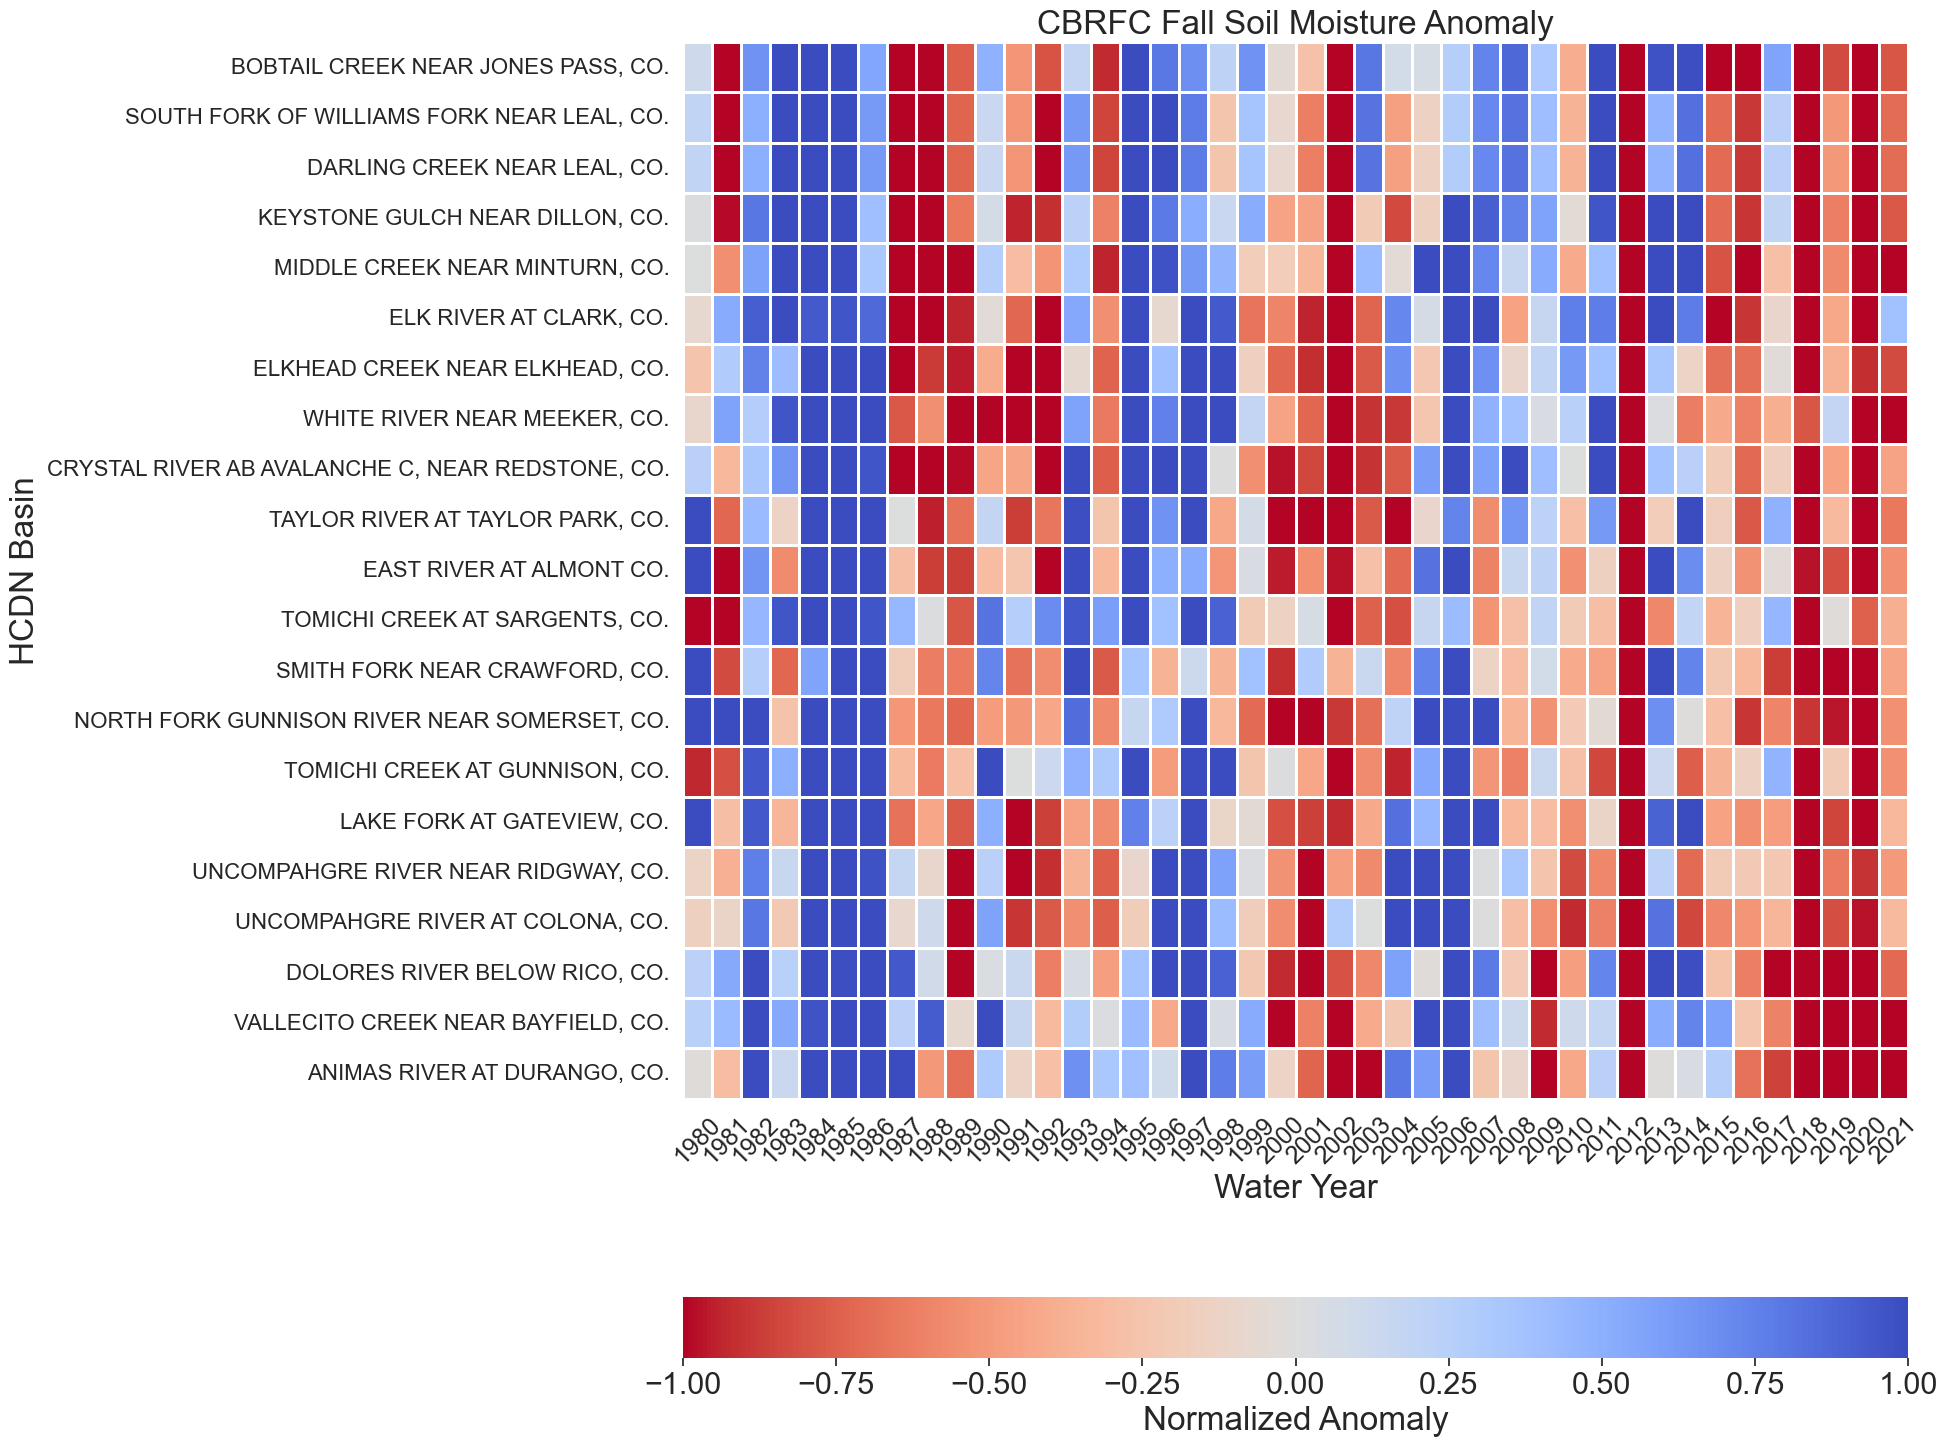

In [56]:
sns.set(font_scale=2)
fig, ax=plt.subplots(nrows=1,figsize=(20,15), facecolor='w',tight_layout=True)
hcdn_sm_transpose = hcdn_fall_soil_moisture_anomaly[sm_cols].T
sns.heatmap(hcdn_sm_transpose, 
            cmap='coolwarm_r', 
            vmin=-1, 
            vmax=1,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.set_yticklabels(hcdn_sm_transpose.index, rotation=0, ha='right', size=16);
ax.set_xticklabels(hcdn_sm_transpose.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('HCDN Basin',size=24)
ax.set_xlabel('Water Year', size=24)
ax.set_title('CBRFC Fall Soil Moisture Anomaly', size=24)


In [ ]:
# Override with the data I want to use for this location
# residual_df['TAYLOR RIVER AT TAYLOR PARK, CO.'] = np.array([ np.nan, 0.34557071, -0.14298503,  0.47592956, -0.01998377, -0.39544826,
#                                                             0.24951214,  0.35746921,  1.53799736,  0.35191506, -0.20010432,
#                                                             -0.33510814,  0.79624942,  0.37863125,  0.82413007, -0.35569593,
#                                                             -0.34242697, -0.62262998, -0.2566138 , -0.42504686,  0.14299915,
#                                                             -0.1662122 ,  0.45736588, -0.09986152,  0.14128553, -0.59512815,
#                                                             0.09032721, -0.04507207,  0.98027981, -0.28053247, -0.61903316,
#                                                             -0.77346242,  0.34928536, -0.94963403, -0.85396863])
# residual_df['EAST RIVER AT ALMONT, CO.'] = np.array([-0.23159395, -0.13285317,  0.01517729,  0.35308609,  0.42713705,
#                                                     -0.21398927, -0.40581044,  0.20014016,  0.61270374,  0.1087555 ,
#                                                     -0.13075471, -0.23426521,  0.41909599,  0.38080882,  0.23119003,
#                                                     -0.52792811, -0.45857949, -0.4540319 , -0.5185571 , -0.14891301,
#                                                         0.02161103, -0.41115783,  0.35298337, -0.02981432,  0.58589907,
#                                                     -0.06006049,  0.23025695,  0.76803584,  0.40207064, -0.14659155,
#                                                     -0.18250982, -0.23335044,  0.53690603, -0.56131493, -0.56378185])

KeyError: "['WHITE RIVER NEAR MEEKER, CO.', 'ELK RIVER AT CLARK, CO.', 'ANIMAS RIVER AT DURANGO, CO.', 'VALLECITO CREEK NEAR BAYFIELD, CO.', 'ELKHEAD CREEK NEAR ELKHEAD, CO.'] not in index"

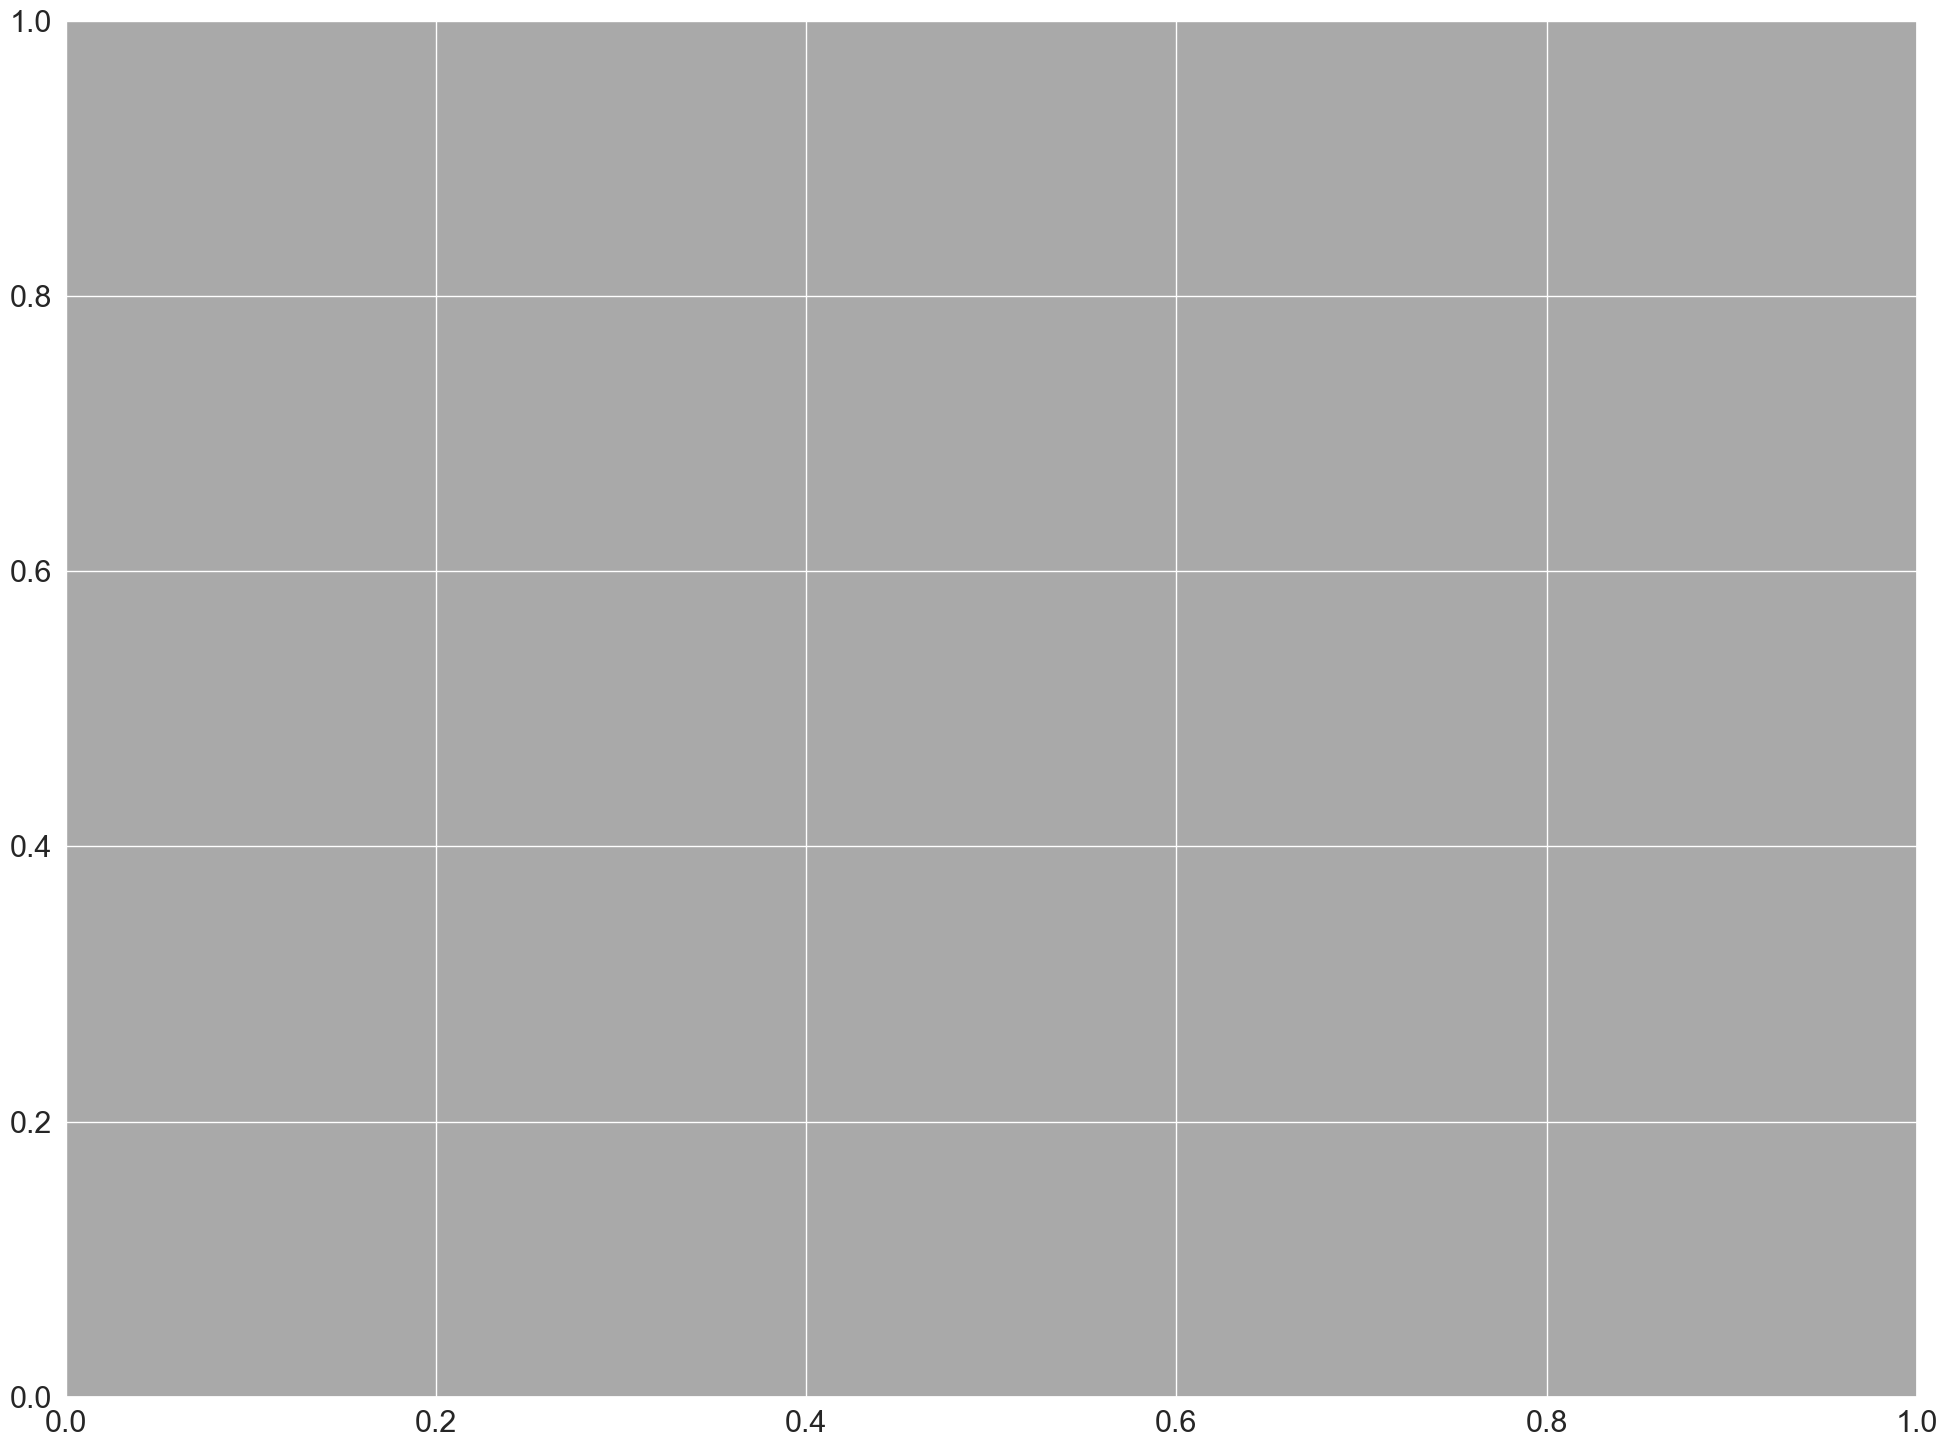

In [ ]:
sns.set(font_scale=2, rc={'axes.facecolor':'darkgrey'})
fig, ax=plt.subplots(nrows=1,figsize=(20,15), facecolor='w',tight_layout=True)
hcdn_residual_transpose = residual_df[sm_cols].T
sns.heatmap(hcdn_residual_transpose, 
            cmap='coolwarm_r', 
            vmin=-1, 
            vmax=1,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.set_yticklabels(hcdn_residual_transpose.index, rotation=0, ha='right', size=16);
ax.set_xticklabels(hcdn_residual_transpose.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('HCDN Basin',size=24)
ax.set_xlabel('Water Year', size=24)
ax.set_title('Normalized SWE-Q Residual', size=24)

In [59]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [60]:
%matplotlib inline

In [24]:
ucrb_basin_boundary = gpd.read_file('../multisite/polygons/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(ucrb_hcdn_basins_rpj_centroids.crs)

NameError: name 'sm_cols' is not defined

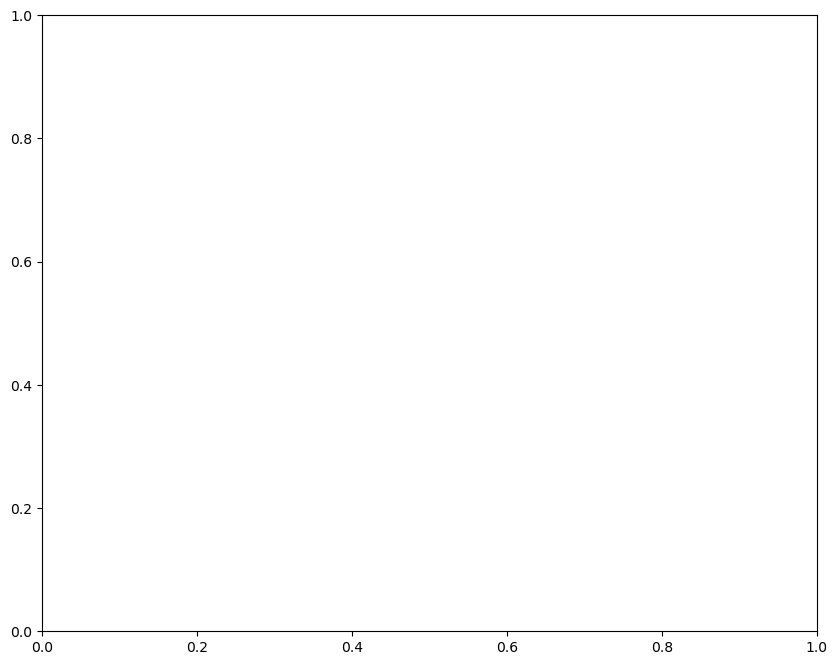

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
year_to_plot = 1995

ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
ucrb_hcdn_basins_rpj_subset[year_to_plot] = hcdn_sm_transpose[year_to_plot].values
# To create full extent
# extent = (ucrb_hcdn_basins_rpj_centroids.x.min()-3e4,
#           ucrb_hcdn_basins_rpj_centroids.x.max()+3e4,
#           ucrb_hcdn_basins_rpj_centroids.y.min()-3e4,
#           ucrb_hcdn_basins_rpj_centroids.y.max()+3e4)
# ax.set_xlim(extent[0], extent[1])
# ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Normalized  Anomaly",},
                      cmap='coolwarm_r',
                      vmin=-1,
                      vmax=1,
                      ec='k',
                      ax=ax) #Name the legend
ucrb_basin_boundary.boundary.plot(ax=ax, label='Upper Colorado River Basin', lw=2)
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# # subregion of the original image 1
# x1, x2, y1, y2 = 4.15e5, 4.35e5, 4.475e6, 4.495e6 
# # inset axes....
# axins = ax.inset_axes([0.8,0.8,0.2,0.2])
# ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
#                       legend = False, #Decide to show legend or not
#                       cmap='coolwarm_r',
#                       vmin=-1,
#                       vmax=1,
#                       ec='k',
#                       ax=axins) #Name the legend
# cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
# # subregion of the original image
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins, edgecolor="black")

# subregion of the original image
# x1, x2, y1, y2 = 3.75e5, 4.3e5, 4.37e6, 4.415e6 
# # inset axes....
# axins_2 = ax.inset_axes([0.15,0.65,0.4,0.4])
# ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
#                       legend = False, #Decide to show legend or not
#                       cmap='coolwarm_r',
#                       vmin=-1,
#                       vmax=1,
#                       ec='k',
#                       ax=axins_2) #Name the legend
# cx.add_basemap(axins_2, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
# # subregion of the original image
# axins_2.set_xlim(x1, x2)
# axins_2.set_ylim(y1, y2)
# axins_2.set_xticklabels([])
# axins_2.set_yticklabels([])
# axins_2.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins_2, edgecolor="black")

# Titles and Axis Labels
ax.set_title(f'HCDN Basin Fall Soil Moisture Anomaly for WY{year_to_plot}\n(Missing values in grey)', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
ax.legend()

# Add broader map of UCRB
# subregion of the original image
# inset axes....
# axins_3 = ax.inset_axes([0.7,0,0.4,0.5])
# ucrb_basin_boundary.boundary.plot(ax=axins_3,) 

# axins_3.text(ucrb_basin_boundary.centroid.x, ucrb_basin_boundary.centroid.y, 'Upper\nColorado\nBasin',
#         fontsize=16, 
#         fontweight='bold',
#         color='k',
#         horizontalalignment='center')

# ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)].geometry.centroid.plot(color='k', linewidth=3, label='HCDN Centroids', edgecolor='k', ax=axins_3)
# cx.add_basemap(axins_3, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution_size=6)

# axins_3.set_xticklabels([])
# axins_3.set_yticklabels([])
# axins_3.tick_params(bottom=False, left=False)
# axins_3.legend()

c:\Users\dlhogan\anaconda3\envs\sos_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


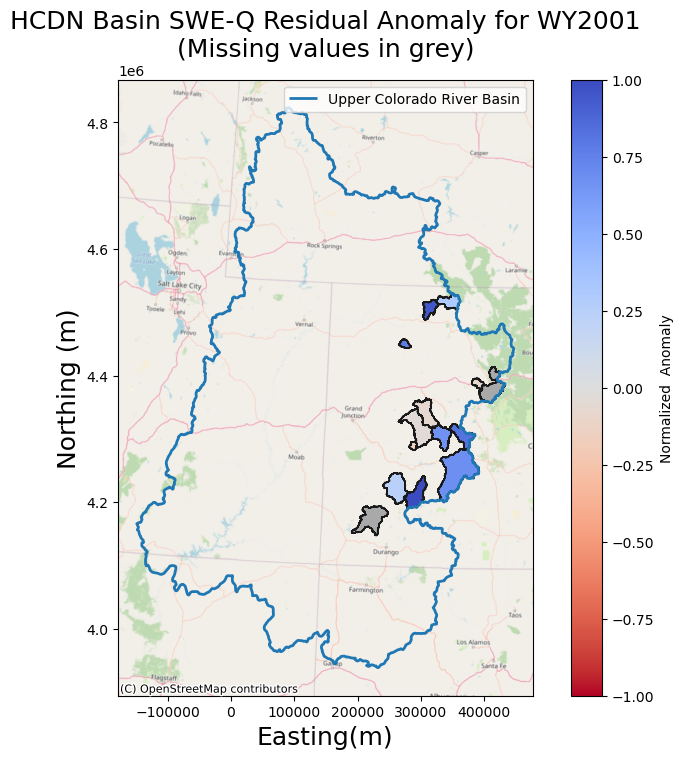

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
year_to_plot = 2001

ucrb_hcdn_basins_rpj_subset = ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)]
ucrb_hcdn_basins_rpj_subset[year_to_plot] = hcdn_residual_transpose.reindex(index=sm_cols)[year_to_plot].values
# To create full extent
# extent = (ucrb_hcdn_basins_rpj_centroids.x.min()-3e4,
#           ucrb_hcdn_basins_rpj_centroids.x.max()+3e4,
#           ucrb_hcdn_basins_rpj_centroids.y.min()-3e4,
#           ucrb_hcdn_basins_rpj_centroids.y.max()+3e4)
# ax.set_xlim(extent[0], extent[1])
# ax.set_ylim(extent[2], extent[3])

#Plot the Choropleth map
ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      legend_kwds = {'label': "Normalized  Anomaly"},
                      missing_kwds= dict(color = "darkgrey",),
                      cmap='coolwarm_r',
                      vmin=-1,
                      vmax=1,
                      ec='k',
                      ax=ax) #Name the legend

ucrb_basin_boundary.boundary.plot(ax=ax, label='Upper Colorado River Basin', lw=2)
cx.add_basemap(ax, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# # subregion of the original image 1
# x1, x2, y1, y2 = 4.15e5, 4.35e5, 4.475e6, 4.495e6 
# # inset axes....
# axins = ax.inset_axes([0.8,0.8,0.2,0.2])
# ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
#                       legend = False, #Decide to show legend or not
#                       cmap='coolwarm_r',
#                       vmin=-1,
#                       vmax=1,
#                       ec='k',
#                       ax=axins) #Name the legend
# cx.add_basemap(axins, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
# # subregion of the original image
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
# axins.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins, edgecolor="black")

# subregion of the original image
# x1, x2, y1, y2 = 3.75e5, 4.3e5, 4.37e6, 4.415e6 
# # inset axes....
# axins_2 = ax.inset_axes([0.15,0.65,0.4,0.4])
# ucrb_hcdn_basins_rpj_subset.plot(column = year_to_plot, #Assign numerical data column
#                       legend = False, #Decide to show legend or not
#                       cmap='coolwarm_r',
#                       missing_kwds= dict(color = "darkgrey",),
#                       vmin=-1,
#                       vmax=1,
#                       ec='k',
#                       ax=axins_2) #Name the legend
# cx.add_basemap(axins_2, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
# # subregion of the original image
# axins_2.set_xlim(x1, x2)
# axins_2.set_ylim(y1, y2)
# axins_2.set_xticklabels([])
# axins_2.set_yticklabels([])
# axins_2.tick_params(bottom=False, left=False)
# ax.indicate_inset_zoom(axins_2, edgecolor="black")

# Titles and Axis Labels
ax.set_title(f'HCDN Basin SWE-Q Residual Anomaly for WY{year_to_plot}\n(Missing values in grey)', size=18)
ax.set_ylabel('Northing (m)', size=18)
ax.set_xlabel('Easting(m)', size=18)
ax.legend()

# Add broader map of UCRB
# subregion of the original image
# inset axes....
# axins_3 = ax.inset_axes([0.7,0,0.4,0.5])
# ucrb_basin_boundary.boundary.plot(ax=axins_3,) 

# # Add label for the basin
# axins_3.text(ucrb_basin_boundary.centroid.x, ucrb_basin_boundary.centroid.y, 'Upper\nColorado\nBasin',
#         fontsize=16, 
#         fontweight='bold',
#         color='k',
#         horizontalalignment='center')

# ucrb_hcdn_basins_rpj[ucrb_hcdn_basins_rpj['STANAME'].isin(sm_cols)].geometry.centroid.plot(color='k', linewidth=3, label='HCDN Basin Locations', edgecolor='k', ax=axins_3)
# cx.add_basemap(axins_3, crs=ucrb_hcdn_basins_rpj_subset.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution_size=6)

# axins_3.set_xticklabels([])
# axins_3.set_yticklabels([])
# axins_3.tick_params(bottom=False, left=False)
# axins_3.legend()


### Time series plots of SWE-Q residual, soil moisture anomalies, and precipitation anomalies

In [193]:
from scipy import stats 
m, b, r, p, sig = stats.linregress(naturalized_flow.index, naturalized_flow.values.T)
X1 = np.array([1906,2021])
y1 = m*X1 + b
m1,b1,r1,p1,sig1 = stats.linregress(naturalized_flow.loc[1980:2020].index, naturalized_flow.loc[1980:2020].values.T)
X2 = np.array([1980,2020])
y2 = m1*X2 + b1


In [195]:
import pymannkendall as mk

In [226]:
hcdn_q_spring_summer_mean_ds

<xarray.Dataset>
Dimensions:     (site_no: 24, year: 41)
Coordinates:
  * site_no     (site_no) object '09034900' '09035800' ... '09352900' '09361500'
  * year        (year) int64 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021
Data variables:
    00060_Mean  (year, site_no) float64 14.63 10.02 35.82 ... 321.5 174.6 669.9

In [231]:
norm_naturalized_flow = ((naturalized_flow-naturalized_flow.mean())/naturalized_flow.std())
norm_hcdn_streamflow = (hcdn_q_spring_summer_mean_ds-hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')

In [279]:
df_list = []
for site in norm_hcdn_streamflow.site_no.values:
    tmp=norm_hcdn_streamflow.sel(site_no=site)['00060_Mean'].to_dataframe()
    tmp = tmp.rename(columns={'00060_Mean':column_dict[site]})
    df_list.append(tmp[column_dict[site]])
norm_hcdn_streamflow_df = pd.concat(df_list, axis=1)        

<Axes: xlabel='year'>

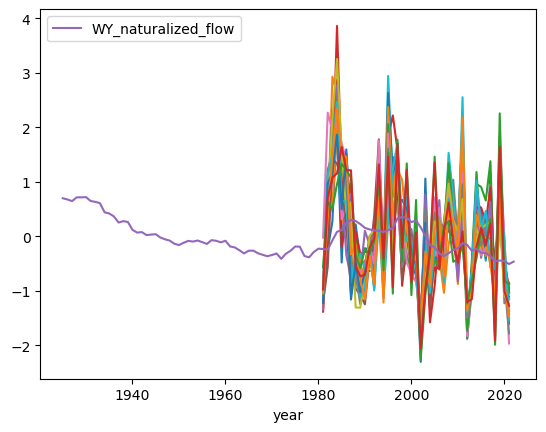

In [289]:
fig, ax =plt.subplots()
naturalized_flow = pd.read_csv('./LF_NATURALIZED_FLOW.csv', index_col=0, header=None, names=['WY_naturalized_flow'])
norm_hcdn_streamflow_df.plot(legend=False,ax=ax)
((naturalized_flow-naturalized_flow.mean())/naturalized_flow.std()).rolling(20).mean().plot(ax=ax)


In [296]:
((naturalized_flow-naturalized_flow.mean())/naturalized_flow.std()).loc[1980:2022].mean()

WY_naturalized_flow   -0.145367
dtype: float64

In [111]:
# Pull in precip anomalies
norm_prism_precip = pd.read_csv('./UCRB_HCDN_CO_PRISM_ANNUAL_PRECIP.csv', index_col='WY')
norm_et_hcdn = pd.read_csv('./HCDN_PET_ANOMALY_POINTS.csv', index_col='Unnamed: 0')
grace_ucrb = pd.read_csv('./UCRB_GRACE_CORRECTED_FILTERED.csv',index_col='time')
grace_ucrb.index = pd.to_datetime(grace_ucrb.index)

(-10.0, 10.0)

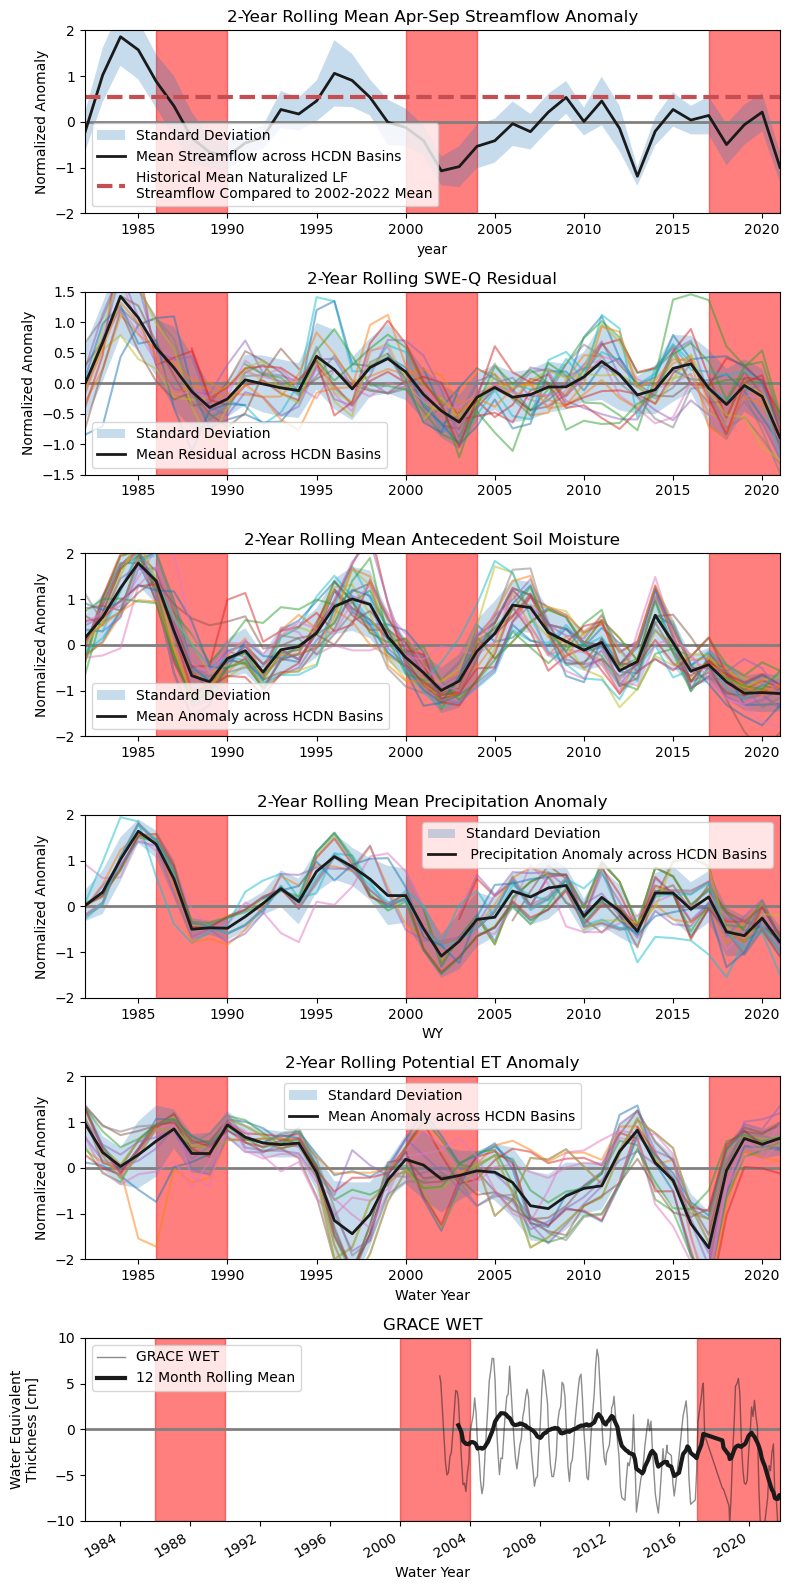

In [308]:
fig, axs = plt.subplots(nrows=6, figsize=(8,16), tight_layout=True)
for ax in axs:
    ax.axhline(0,color='grey', lw=2)
    ax.set_xlim(1982,2022)
    ax.set_ylabel('Normalized Anomaly')
    ax.axvspan(1986,1990,alpha=0.5, color='red')
    ax.axvspan(2000,2004,alpha=0.5, color='red')
    # ax.axvspan(2011,2015,alpha=0.5, color='red')
    ax.axvspan(2017,2023,alpha=0.5, color='red')
#################################
# Plot 0 - Streamflow
ax=axs[0]
ax.fill_between(x=norm_hcdn_streamflow_df.rolling(2).mean().index,
                y1=norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean()+norm_hcdn_streamflow_df.std(axis=1).rolling(2).mean(),
                y2=norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean()-norm_hcdn_streamflow_df.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

# for col in norm_hcdn_streamflow_df.columns:
    # ax.plot(norm_hcdn_streamflow_df[col].rolling(2).mean().index, norm_hcdn_streamflow_df[col].rolling(2).mean(),alpha=0.5)
norm_hcdn_streamflow_df.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Mean Streamflow across HCDN Basins')
ax.axhline(np.abs(((naturalized_flow-naturalized_flow.mean())/naturalized_flow.std()).loc[2002:2022].mean()).values[0], ls='--', color='r', lw=3, label='Historical Mean Naturalized LF\nStreamflow Compared to 2002-2022 Mean')
ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Mean Apr-Sep Streamflow Anomaly')
#################################
# Plot 1 - SWE-Q residual
ax=axs[1]
ax.fill_between(x=residual_df.rolling(2).mean().index,
                y1=residual_df.mean(axis=1).rolling(2).mean()+residual_df.std(axis=1).rolling(2).mean(),
                y2=residual_df.mean(axis=1).rolling(2).mean()-residual_df.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in residual_df.columns:
    ax.plot(residual_df[col].rolling(2).mean().index, residual_df[col].rolling(2).mean(),alpha=0.5)
residual_df.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Mean Residual across HCDN Basins')
ax.legend()
ax.set_ylim(-1.5,1.5)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling SWE-Q Residual')
#################################
# Plot 2 - Soil Moisture Anomaly
ax=axs[2]
ax.fill_between(x=hcdn_fall_soil_moisture_anomaly.rolling(2).mean().index,
                y1=hcdn_fall_soil_moisture_anomaly.mean(axis=1).rolling(2).mean()+hcdn_fall_soil_moisture_anomaly.std(axis=1).rolling(2).mean(),
                y2=hcdn_fall_soil_moisture_anomaly.mean(axis=1).rolling(2).mean()-hcdn_fall_soil_moisture_anomaly.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in hcdn_fall_soil_moisture_anomaly.columns:
    ax.plot(hcdn_fall_soil_moisture_anomaly[col].rolling(2).mean().index, hcdn_fall_soil_moisture_anomaly[col].rolling(2).mean(),alpha=0.5)
hcdn_fall_soil_moisture_anomaly.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Mean Anomaly across HCDN Basins')
ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Mean Antecedent Soil Moisture')
#################################
# Plot 3 - Precipitation Anomaly
ax=axs[3]
ax.fill_between(x=norm_prism_precip.rolling(2).mean().index,
                y1=norm_prism_precip.mean(axis=1).rolling(2).mean()+norm_prism_precip.std(axis=1).rolling(2).mean(),
                y2=norm_prism_precip.mean(axis=1).rolling(2).mean()-norm_prism_precip.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in norm_prism_precip.columns:
    ax.plot(norm_prism_precip[col].rolling(2).mean().index, norm_prism_precip[col].rolling(2).mean(),alpha=0.5)
norm_prism_precip.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label=' Precipitation Anomaly across HCDN Basins')
ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
# ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Mean Precipitation Anomaly')
#################################
# Plot 4 - ET Anomaly
ax=axs[4]
ax.fill_between(x=norm_et_hcdn.rolling(2).mean().index,
                y1=norm_et_hcdn.mean(axis=1).rolling(2).mean()+norm_et_hcdn.std(axis=1).rolling(2).mean(),
                y2=norm_et_hcdn.mean(axis=1).rolling(2).mean()-norm_et_hcdn.std(axis=1).rolling(2).mean(),
                alpha=0.25, 
                label='Standard Deviation',
                interpolate=True)

for col in norm_et_hcdn.columns:
    ax.plot(norm_et_hcdn[col].rolling(2).mean().index, norm_et_hcdn[col].rolling(2).mean(),alpha=0.5)
norm_et_hcdn.mean(axis=1).rolling(2).mean().plot(ax=ax, lw=2, color='k', label='Mean Anomaly across HCDN Basins')
ax.legend()
ax.set_ylim(-2,2)
ax.set_xlim(1982,2021)
ax.set_xlabel('Water Year')
ax.set_title('2-Year Rolling Potential ET Anomaly')
#################################
# Plot 5 - GRACE WET Change
ax=axs[5]
ax.axvspan(dt.date(1986,1,1),dt.date(1990,1,1),alpha=0.5, color='red')
ax.axvspan(dt.date(2000,1,1),dt.date(2004,1,1),alpha=0.5, color='red')
# ax.axvspan(2011,2015,alpha=0.5, color='red')
ax.axvspan(dt.date(2017,1,1),dt.date(2023,1,1),alpha=0.5, color='red')
grace_ucrb['lwe_thickness'].plot(ax=ax, lw=1, color='k', label='GRACE WET', alpha=0.5)
grace_ucrb['lwe_thickness'].rolling(12).mean().plot(ax=ax, lw=3, color='k', label='12 Month Rolling Mean')
ax.legend()
ax.set_xlim(dt.date(1982,1,1),dt.date(2021,10,1))
ax.set_xlabel('Water Year')
ax.set_title('GRACE WET')
ax.set_ylabel('Water Equivalent\nThickness [cm]')
ax.set_ylim(-10,10)





### Groundwater

In [290]:
ucrb_swb_model = pd.read_csv('../../data/800m_4km_10pc_runoff_monthly_SUMS_m3.txt', sep='\s+')

In [291]:
ucrb_gw_model_results = ucrb_gw_model_results = ucrb_swb_model[(ucrb_swb_model['SWB_Model_Run'].str.contains('RECHARGE'))]
ucrb_gw_model_results['myDt'] = ucrb_gw_model_results.apply(lambda row: dt.datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{1}", '%Y-%m-%d'), axis=1)
ucrb_gw_model_results = ucrb_gw_model_results.set_index('myDt', drop=True)
ucrb_gw_model_results['WY'] = ucrb_gw_model_results.index.year.where(ucrb_gw_model_results.index.month < 10, ucrb_gw_model_results.index.year + 1)
ucrb_gw_model_results

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_6884\101151172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucrb_gw_model_results['myDt'] = ucrb_gw_model_results.apply(lambda row: dt.datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{1}", '%Y-%m-%d'), axis=1)


,SWB_Model_Run,Year,Month,Parameter_Sum_m3,WY
myDt,,,,,
1981-01-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,1981,1,1.401909e+08,1981
1981-02-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,1981,2,9.443194e+07,1981
1981-03-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,1981,3,1.116770e+08,1981
1981-04-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,1981,4,2.564375e+09,1981
1981-05-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,1981,5,1.418298e+09,1981
...,...,...,...,...,...
2014-08-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,2014,8,4.445419e+07,2014
2014-09-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,2014,9,1.143063e+08,2014
2014-10-01,UCRB_800m_4km_1981-2014_3-13-17_10pc_runoff_RE...,2014,10,9.649352e+07,2015


In [292]:
gw_well_dtw = []
for file in os.listdir('./groundwater_data/'):
    tmp = pd.read_csv(f'./groundwater_data/{file}')
    well_name=list(tmp['Well Name'].unique())[0]

    # if 'WS-06A' in file:
    tmp.index = pd.to_datetime(tmp['Date'])
    tmp = tmp[tmp.index>dt.datetime(1985,10,1)]
    tmp['WY'] = tmp.index.year.where(tmp.index.month < 10, tmp.index.year + 1)
    df_annual = tmp.groupby(tmp.WY).mean()
    df_annual['Date'] = df_annual.apply(lambda row: dt.datetime.strptime(f"{(row.name)}-{1}-{1}", '%Y-%m-%d'), axis=1)
    df_annual=df_annual.reset_index(drop=True)
    df_annual[well_name] = -(df_annual['Depth to Water (ft)'] - df_annual['Depth to Water (ft)'].mean())/df_annual['Depth to Water (ft)'].std()
    gw_well_dtw.append(df_annual[['Date',well_name]])
    # else:
    #     tmp[well_name] = -(tmp['Depth to Water (ft)'] - tmp['Depth to Water (ft)'].mean())/tmp['Depth to Water (ft)'].std()
    #     tmp = tmp[np.abs(tmp[well_name])<4 ]
    #     gw_well_dtw.append(tmp[['Date',well_name]])

In [293]:
gw_well_dtw_df = pd.concat(gw_well_dtw,axis=0)
gw_well_dtw_df.index = pd.to_datetime(gw_well_dtw_df.Date)

Text(0, 0.5, 'Normalized Depth to Water')

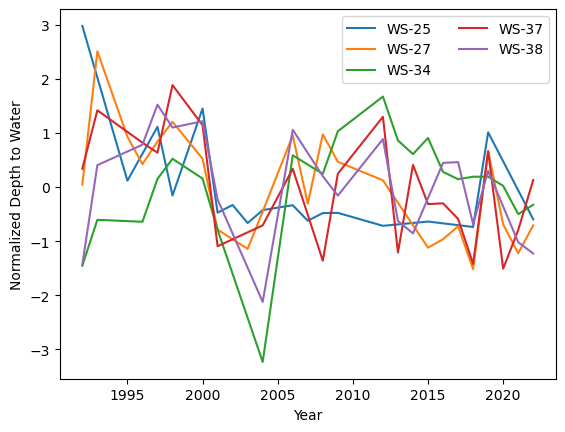

In [294]:
for col in gw_well_dtw_df.columns:
    if col not in ['Date','WS-06A','WS-43']:
        to_plot = gw_well_dtw_df[col].dropna()
        to_plot.groupby(to_plot.index.year).mean().plot()
plt.legend(ncol=2)
plt.xlabel('Year')
plt.ylabel('Normalized Depth to Water')

Text(0.5, 1.0, 'UCRB DWR Well Depth to Water')

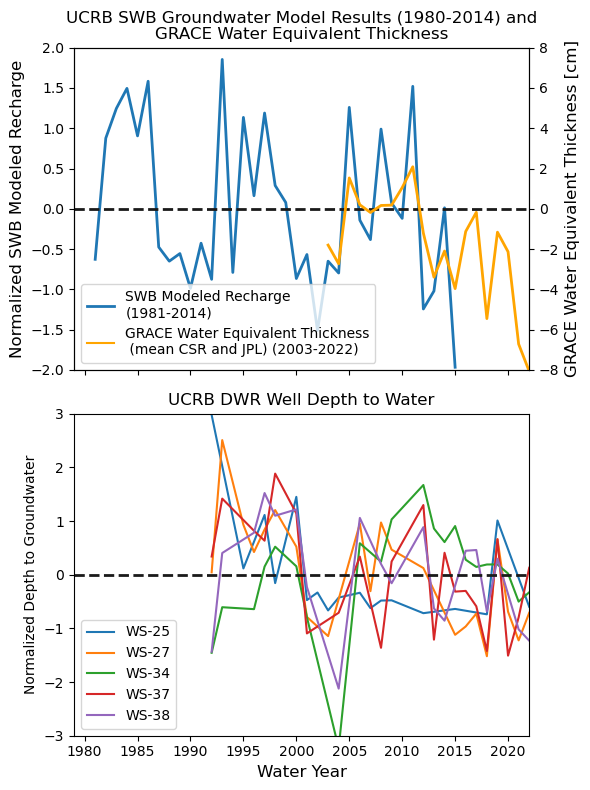

In [305]:
fig, axs = plt.subplots(nrows=2, figsize=(6,8), tight_layout=True, sharex=True)
# Plot UCRB subbasin means and standard deviations for each year from model output with RCP 4.5 1950-2099 
wy_mean = ucrb_gw_model_results['Parameter_Sum_m3'].groupby(ucrb_gw_model_results['WY']).mean()

((wy_mean-wy_mean.mean())/wy_mean.std()).plot(ax=axs[0],
                                              label='SWB Modeled Recharge\n(1981-2014)',
                                              lw=2)
axs[0].plot([],[], label='GRACE Water Equivalent Thickness\n (mean CSR and JPL) (2003-2022)',color='orange')

# Plot Grace satellite data
grace_data = pd.read_csv('timeseries_water_GRACE.csv', index_col=0)
grace_data.index = pd.to_datetime(grace_data.index)
grace_data['WY'] = grace_data.index.year.where(grace_data.index.month<10, grace_data.index.year+1)
grace_data = grace_data.groupby(grace_data.WY).mean().drop([2002,2023])
ax2=axs[0].twinx()
for col in grace_data:
    grace_data[f'{col[-13:-1]}_norm'] = (grace_data[col])
grace_data[['GRACE-FO JPL_norm','GRACE-FO CSR_norm']].mean(axis=1).plot(ax=ax2, 
                                                                        lw=2,
                                                                        color='orange')
ax2.set_ylim(-8,8)                                        
# For drought severity index
# drought_severity_index = pd.read_json('./dm_export_19871001_20220930_2.json')
# drought_severity_index.index = pd.to_datetime(drought_severity_index.ValidStart)
# drought_severity_index = drought_severity_index.sort_index()
# drought_severity_index['WY'] = drought_severity_index.index.year.where(drought_severity_index.index.month<10,drought_severity_index.index.year+1)
# plt_drought=(drought_severity_index.groupby('WY').mean()[['D1','D2','D3','D4']].sum(axis=1)>50).replace({False:np.nan}).dropna().index
# for year in plt_drought:
#     ax.fill_between([year, year+1], -2,2, alpha=0.5, color='red')
axs[0].axhline(0, color='k', ls='--', lw=2)
axs[0].set_ylabel('Normalized SWB Modeled Recharge', size=12)
ax2.set_ylabel('GRACE Water Equivalent Thickness [cm]', size=12)
axs[0].legend()
axs[0].set_ylim(-2,2)
axs[0].set_xlim(1979,2022)
# axs[0].set_xticks(ticks=np.arange(1981,2023,2));
# axs[0].set_xticklabels(labels=np.arange(1981,2023,2),rotation=45);
axs[0].set_title('UCRB SWB Groundwater Model Results (1980-2014) and\nGRACE Water Equivalent Thickness')

# Water level plots 
for col in gw_well_dtw_df.columns:
    if col not in ['Date','WS-06A', 'WS-43']:
        to_plot = gw_well_dtw_df[gw_well_dtw_df.index.year>=1990][col].dropna()
        to_plot.groupby(to_plot.index.year).mean().plot(ax=axs[1])
axs[1].axhline(0, color='k', ls='--', lw=2)
axs[1].set_ylim(-3,3)
axs[1].set_xlim(1979,2022)
axs[1].legend(loc='lower left')
axs[1].set_xlabel('Water Year', size=12)
axs[1].set_ylabel('Normalized Depth to Groundwater')
axs[1].set_title('UCRB DWR Well Depth to Water')

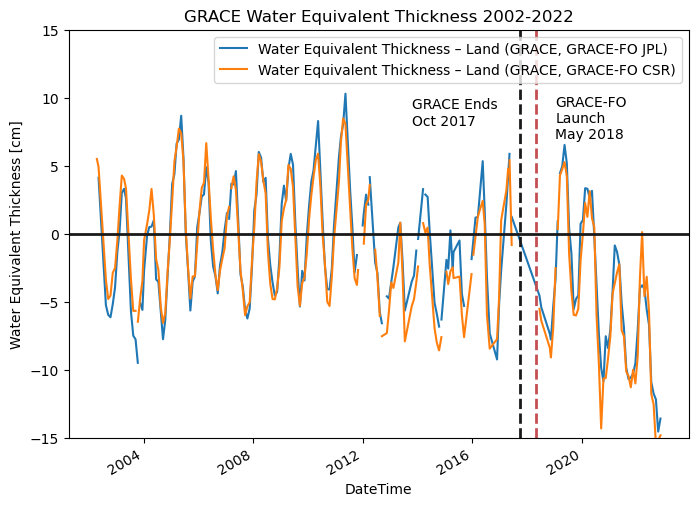

In [379]:
fig, ax = plt.subplots(figsize=(8,6))
grace_data = pd.read_csv('timeseries_water_GRACE.csv', index_col=0)
grace_data.index = pd.to_datetime(grace_data.index)
grace_data.plot(ax=ax)
grace_data['WY'] = grace_data.index.year.where(grace_data.index.month<10, grace_data.index.year+1)
ax.axvline(dt.date(2017,10,1), color='k', lw=2, ls='--')
ax.axvline(dt.date(2018,5,1), color='r', lw=2, ls='--')
ax.text(x=dt.date(2013,10,15),y=8,s='GRACE Ends\nOct 2017',)
ax.text(x=dt.date(2019,1,15),y=7,s='GRACE-FO\nLaunch\nMay 2018')
ax.set_ylabel('Water Equivalent Thickness [cm]')
ax.set_title('GRACE Water Equivalent Thickness 2002-2022')
ax.set_ylim(-15,15)
ax.axhline(0,color='k',lw=2)

(-15.0, 15.0)

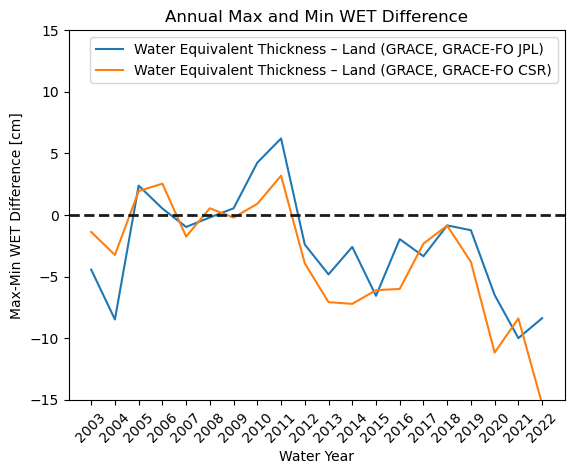

In [382]:
fig, ax = plt.subplots()
# grace_data.groupby(grace_data['WY']).max().plot(ax=ax)
# grace_data.groupby(grace_data['WY']).min().plot(ax=ax)
(np.abs(grace_data.groupby(grace_data['WY']).max().drop([2002,2023]))-np.abs(grace_data.groupby(grace_data['WY']).min().drop([2002,2023]))).plot(ax=ax)
ax.axhline(0,lw=2,color='k',ls='--')
ax.set_xticks(np.arange(2003,2023,1))
ax.set_xticklabels(np.arange(2003,2023,1), rotation=45);
ax.set_ylabel('Max-Min WET Difference [cm]')
ax.set_xlabel('Water Year')
ax.set_title('Annual Max and Min WET Difference')
ax.set_ylim(-15,15)

In [809]:
well_locs={
    'WS-25':{'lat':37.161107,
             'lon':-107.315298},
    'WS-27':{'lat':38.934691,
             'lon':-107.767157},
    'WS-34':{'lat':39.490665,
             'lon':-107.865712},
    'WS-37':{'lat':39.452551,
             'lon':-107.767157},
    'WS-38':{'lat':39.444236,	
             'lon':-108.390048},
    # 'WS-43':{'lat':37.159519,	
    #          'lon':-107.678339},
}

In [810]:
well_loc_df = pd.DataFrame.from_dict(well_locs,orient='index')
well_loc_gdf = gpd.GeoDataFrame(well_loc_df,
                                geometry=gpd.points_from_xy(well_loc_df.lon,well_loc_df.lat),
                                crs='4326'
                                )
well_loc_gdf = well_loc_gdf.to_crs('32613')

In [390]:
0

0

In [132]:
landsat_ndvi = pd.read_csv('./landsat/ee-chart.csv').dropna()
landsat_ndvi.index =  pd.to_datetime(landsat_ndvi['system:time_start'])

landsat_ndvi_2 = pd.read_csv('./landsat/ee-chart_hotchiss.csv').dropna()
landsat_ndvi_2.index =  pd.to_datetime(landsat_ndvi_2['system:time_start'])

landsat_ndvi_3 = pd.read_csv('./landsat/ee-chart_dryriparian.csv').dropna()
landsat_ndvi_3.index =  pd.to_datetime(landsat_ndvi_3['system:time_start'])

landsat_ndvi_ucrb = pd.read_csv('./landsat/ee-chart_ucrb.csv').dropna()
landsat_ndvi_ucrb.index =  pd.to_datetime(landsat_ndvi_ucrb['system:time_start'])

Text(0, 0.5, 'NDVI')

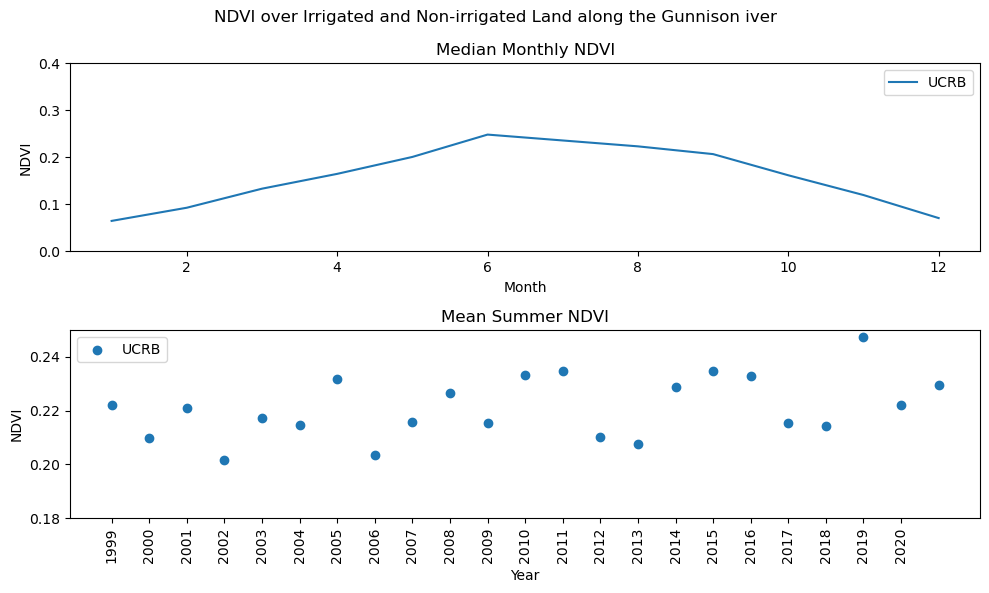

In [154]:
summer_landsat_ndvi = landsat_ndvi[landsat_ndvi.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_2 = landsat_ndvi_2[landsat_ndvi_2.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_3 = landsat_ndvi_3[landsat_ndvi_3.index.month.isin([7,8,9])]['NDVI']
summer_landsat_ndvi_ucrb = landsat_ndvi_ucrb[landsat_ndvi_ucrb.index.month.isin([7,8,9])]['NDVI']
fig, [ax1,ax2] = plt.subplots(2, tight_layout=True, figsize=(10,6))
fig.suptitle('NDVI over Irrigated and Non-irrigated Land along the Gunnison iver')

# landsat_ndvi['NDVI'].groupby(landsat_ndvi.index.month).median().plot(ax=ax1, label='Gunnison (Irrigated Zone 1 - 5800 ft)')
# landsat_ndvi_2['NDVI'].groupby(landsat_ndvi_2.index.month).median().plot(ax=ax1, label='NF Gunnison (Irrigated Zone 2 - 5700 ft)')
# landsat_ndvi_3['NDVI'].groupby(landsat_ndvi_3.index.month).median().plot(ax=ax1, label='Gunnison (Non-Irrigated Zone 1 - 7600 ft)')
landsat_ndvi_ucrb['NDVI'].groupby(landsat_ndvi_ucrb.index.month).median().plot(ax=ax1, label='UCRB')
ax1.set_title('Median Monthly NDVI')
ax1.legend()
ax1.set_xlabel('Month')
ax1.set_ylabel('NDVI')
ax1.set_ylim(0.0,0.4)

# summer_landsat_ndvi.groupby(summer_landsat_ndvi.index.year).mean().plot(ax=ax2, label='Gunnison (Irrigated Zone 1 - 5800 ft)')
# summer_landsat_ndvi_2.groupby(summer_landsat_ndvi_2.index.year).mean().plot(ax=ax2, label='NF Gunnison (Irrigated Zone 2 - 5700 ft)')
# summer_landsat_ndvi_3.groupby(summer_landsat_ndvi_3.index.year).mean().plot(ax=ax2, label='Gunnison (Non-Irrigated Zone 1 - 7600 ft)')
fit  = np.polyfit(summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean().index,summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean(), deg =1)
ax2.scatter(summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean().index,summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean(), label='UCRB')


ax2.legend(loc='upper left')
ax2.set_title('Mean Summer NDVI')
ax2.set_xticks(np.arange(1999,2021,1))
ax2.set_ylim(0.18,0.25)
ax2.set_xticklabels(labels=np.arange(1999,2021,1), rotation=90)
ax2.set_xlabel('Year')
ax2.set_ylabel('NDVI')

In [155]:
import pymannkendall as mk

mk.original_test(summer_landsat_ndvi_ucrb.groupby(summer_landsat_ndvi_ucrb.index.year).mean())

Mann_Kendall_Test(trend='no trend', h=False, p=0.11305101958707042, z=1.5846273830995752, Tau=0.24110671936758893, s=61.0, var_s=1433.6666666666667, slope=0.0006470588235294091, intercept=0.2140490196078432)